<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [*De Novo* Protein Design with PyRosetta](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.07-Introduction-to-DeNovo-protein-design.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Docking](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/07.00-Protein-Docking.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.08-Point-Mutation-Scan.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# **Point Mutation Scan**

Keywords: FastRelax, ResidueSelector, NeighborhoodResidueSelector, TaskFactory, TaskOperation, RestrictToRepackingRLT, RestrictAbsentCanonicalAASRLT, NoRepackDisulfides, OperateOnResidueSubset, RigidBodyTransMover, ggplot2

## Overview
The purpose of this section is to create a protocol using what you have learned in the previous sections.  In this tutorial, we will prepare an antibody-antigen bound structure, make point mutations on the antibody, records changes in binding enregy, and generate a heatmap demonstrating energy differences. This method is widely used in antibody interface design for either improving binding affinity or expanding the binding range. 



## Protocol
The whole protocol is broken down by eight steps.

**Step 1.** Prepare the structure with FastRelax()

**Step 2.** Write the function to perform the mutation PackMover()

**Step 3.** Write the function to unbind the antibody-antigen bound structure unbind()

**Step 4.** Write the function to get wildtype amino acid

**Step 5.** Write the function to properly mutate and pack a specific residue and output energy metrics

**Step 6.** Loop through interface positions mutating them into 20 amino acids with output files

**Step 7.** Summarize all input files for binding energy analysis




## **Section Contributors:**
Yuanhan Wu (The Wistar Institute)

Daniel Kulp (The Wistar Institute)

Jared Adolf-Bryfogle (Scripps; Institute for Protein Innovation)

Ajasja Ljubetič (University of Washington)

### Set up notebook

In [13]:
# Notebook setup
import sys
if 'google.colab' in sys.modules:
    !pip install pyrosettacolabsetup
    import pyrosettacolabsetup
    pyrosettacolabsetup.setup()
    print ("Notebook is set for PyRosetta use in Colab.  Have fun!")

**Make sure you are in the directory with the pdb files:**

`cd google_drive/My\ Drive/student-notebooks/`

### Loading structures 

In [14]:
from pyrosetta import * 
init()
pose = pose_from_pdb("inputs/1jhl.clean.pdb")
testPose = Pose()
testPose.assign(pose)
print(testPose)

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python36.mac 2019.39+release.93456a567a8125cafdf7f8cb44400bc20b570d81 2019-09-26T14:24:44] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Reading fconfig.../Users/jadolfbr/.rosetta/flags/common
core.init: 
core.init: 
core.init: Rosetta version: PyRosetta4.Release.python36.mac r233 2019.39+release.93456a567a8 93456a567a8125cafdf7f8cb44400bc20b570d81 http://www.pyrosetta.org 2019-09-26T14:24:44
core.init: command: PyRosetta -ex1 -ex2aro -database /Users/jadolfbr/Library/Python/3.6/lib/python/site-packages/pyrosetta-2019.39+release.93456a567a8-py3.6-macosx-10.6-intel.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-323604717 seed_offset=0 real_seed=-323604717
basic.random.init_random_generator: RandomGenerator:in

## **Step 1. Prepare the starting structure with FastRelax()**

Properly relaxing a structure is crucial in design with Rosetta. A non relaxed structure may not overcome bad global energy well and therefore skew the following analysis on binding energy.

A FastRelax() is used to relax the structrue. While we want to put the sturcture in its lowest energy state, we want to keep the backbone information from the crystal structure as much as possible (lowest RMSD). Therefore, we apply constrain_relax_to_start_coords(True) to FastRelax().

Since FastRelax() is taking up a huge amount of resource, running it seems to crash the notebook, we commented out the "apply" part (the part that perform the relax) and print out the relaxMover() instead. We uploaded the relaxed structure to the input folder for furthre analysis.

Coordinate constrained relax is a general prep.  For a more advanced version of this preparation method, see the [ pareto-optimal method by Nivon, Morreti, and Baker ](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0059004)



In [15]:
from pyrosetta.rosetta.protocols.relax import FastRelax

relax = FastRelax()
scorefxn = get_fa_scorefxn()
relax.set_scorefxn(scorefxn)
relax = rosetta.protocols.relax.FastRelax()
relax.constrain_relax_to_start_coords(True)
print(relax)
#relax.apply(testPose)
#testPose.dump_pdb('test.relax.pdb')

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015


### Writing Function in Python

Functions are good ways to organize your code. Starting from this section I am introducing serveral functions to facilitate the protocol.

To define a function in python, a "def" key word is used. A function can either returns a value or simply executing code blocks. A defined function can be called in main function or other sections of code too.

## **Step 2. Write the function for mutation**

This function utilizes the **ResidueSelectorMover()** as demonstrated by previous tutorials. Mutated position is allowed to be designed and repacked while the neighborhood residues are limited to repacked only. The final mutation will be performed with a **PackMover()**.

In [16]:
from pyrosetta.rosetta.core.pack.task import *
from pyrosetta.rosetta.protocols import *
from pyrosetta.rosetta.core.select import *

def pack(pose, posi, amino, scorefxn):

    # Select Mutate Position
    mut_posi = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector()
    mut_posi.set_index(posi)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(mut_posi.apply(pose)))

    # Select Neighbor Position
    nbr_selector = pyrosetta.rosetta.core.select.residue_selector.NeighborhoodResidueSelector()
    nbr_selector.set_focus_selector(mut_posi)
    nbr_selector.set_include_focus_in_subset(True)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(nbr_selector.apply(pose)))

    # Select No Design Area
    not_design = pyrosetta.rosetta.core.select.residue_selector.NotResidueSelector(mut_posi)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(not_design.apply(pose)))

    # The task factory accepts all the task operations
    tf = pyrosetta.rosetta.core.pack.task.TaskFactory()

    # These are pretty standard
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.InitializeFromCommandline())
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.IncludeCurrent())
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.NoRepackDisulfides())

    # Disable Packing
    prevent_repacking_rlt = pyrosetta.rosetta.core.pack.task.operation.PreventRepackingRLT()
    prevent_subset_repacking = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(prevent_repacking_rlt, nbr_selector, True )
    tf.push_back(prevent_subset_repacking)

    # Disable design
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(
        pyrosetta.rosetta.core.pack.task.operation.RestrictToRepackingRLT(),not_design))

    # Enable design
    aa_to_design = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASRLT()
    aa_to_design.aas_to_keep(amino)
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(aa_to_design, mut_posi))
    
    # Create Packer
    packer = pyrosetta.rosetta.protocols.minimization_packing.PackRotamersMover()
    packer.task_factory(tf)

    #Perform The Move
    if not os.getenv("DEBUG"):
      packer.apply(pose)

#Load the previously-relaxed pose.
relaxPose = pose_from_pdb("inputs/1jhl.relax.pdb")

#Clone it
original = relaxPose.clone()
scorefxn = get_score_function()
print("\nOld Energy:", scorefxn(original),"\n")
pack(relaxPose, 130, 'A', scorefxn)
print("\nNew Energy:", scorefxn(relaxPose),"\n")

#Set relaxPose back to original
relaxPose = original.clone()


core.import_pose.import_pose: File 'inputs/1jhl.relax.pdb' automatically determined to be of type PDB
core.io.pdb.pdb_reader: Parsing 359 .pdb records with unknown format to search for Rosetta-specific comments.
core.conformation.Conformation: Found disulfide between residues 230 351
core.conformation.Conformation: current variant for 230 CYS
core.conformation.Conformation: current variant for 351 CYS
core.conformation.Conformation: current variant for 230 CYD
core.conformation.Conformation: current variant for 351 CYD
core.conformation.Conformation: Found disulfide between residues 130 204
core.conformation.Conformation: current variant for 130 CYS
core.conformation.Conformation: current variant for 204 CYS
core.conformation.Conformation: current variant for 130 CYD
core.conformation.Conformation: current variant for 204 CYD
core.conformation.Conformation: Found disulfide between residues 23 88
core.conformation.Conformation: current variant for 23 CYS
core.conformation.Conformation: 

### **Step 3. unbind()**
This function is for binding energy analysis. To compute a binding energy, we need to score the total energy of a bound state structure, separate (unbind) the antigen and antibody and then score the unbound state total energy. The binding energy is given by **bound energy** - **unbound energy**.  You can also use the **InterfaceAnalyzerMover (IAM)** , located in `rosetta.protocols.analysis`.

- Benefits to unbind over IAM:
 - Quicker
 - Simpler
 
- Disadvantages to unbind over IAM:
 - Specific foldtree needs to used, with a specific jump. For IAM - it is now foldtree independent, so you only need to know the chainIDs on each side of the interface. 

In [17]:
from pyrosetta.rosetta.protocols import *

def unbind(pose, partners):
    STEP_SIZE = 100
    JUMP = 2
    docking.setup_foldtree(pose, partners, Vector1([-1,-1,-1]))
    trans_mover = rigid.RigidBodyTransMover(pose,JUMP)
    trans_mover.step_size(STEP_SIZE)
    trans_mover.apply(pose)


##Reset the original pose
relaxPose = original.clone()

scorefxn = get_score_function()
bound_score = scorefxn(relaxPose)
print("\nBound State Score",bound_score,"\n")
unbind(relaxPose, "HL_A")
unbound_score = scorefxn(relaxPose)

print("\nUnbound State Score", unbound_score,"\n")
print('dG', bound_score - unbound_score, 'Rosetta Energy Units (REU)')


core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015

Bound State Score -1056.7706161583792 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -24.7339 16.9267 23.6626
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517

Unbound State Score -998.7222028352029 

dG -58.048413323176305 Rosetta Energy Units (REU)


## **Step 4. wildtype()**

An important metrics for evaluating binding improvement is the ratio of mutant binding energy to wild type binding energy. This function returns the wild type amino acids in a given position. 

In [34]:
def wildtype(aatype = 'AA.aa_gly'):
    AA = ['G','A','L','M','F','W','K','Q','E','S','P'
            ,'V','I','C','Y','H','R','N','D','T']

    AA_3 = ['AA.aa_gly','AA.aa_ala','AA.aa_leu','AA.aa_met','AA.aa_phe','AA.aa_trp'
            ,'AA.aa_lys','AA.aa_gln','AA.aa_glu', 'AA.aa_ser','AA.aa_pro','AA.aa_val'
            ,'AA.aa_ile','AA.aa_cys','AA.aa_tyr','AA.aa_his','AA.aa_arg','AA.aa_asn'
            ,'AA.aa_asp','AA.aa_thr']

    for i in range(0, len(AA_3)):
        if(aatype == AA_3[i]):
            return AA[i]

print(wildtype(str(relaxPose.aa(130))))


C


# Setp 4a.  Exploration. 

We can also use some utility functions instead of this function. 

We can use the sequence STRING returned.  Note that strings are indexed at 0 in Rosetta. 

In [28]:

print(relaxPose.sequence())
print("\n",relaxPose.sequence()[129])

DIELTQSPSYLVASPGETITINCRASKSISKSLAWYQEKPGKTNNLLIYSGSTLQSGIPSRFSGSGSGTDFTLTISSLEPEDFAMYICQQHNEYPWTFGGGTKLEIKRQVQLQQSGAELVRPGASVKLSCKASGYTFISYWINWVKQRPGQGLEWIGNIYPSDSYTNYNQKFKDKATLTVDKSSSTAYMQLSSPTSEDSAVYYCTRDDNYGAMDYWGQGTTVTVKVYGRCELAAAMKRMGLDNYRGYSLGNWVCAAKFESNFNTGATNRNTDGSTDYGILQINSRWWCNDGRTPGSKNLCHIPCSALLSSDITASVNCAKKIVSDGDGMNAWVAWRKHCKGTDVNVWIRGCRL

 C


Now lets get some information fromt the ResidueType object that holds chemical information. 


In [29]:
print(relaxPose.residue_type(130))

CYS:disulfide (CYS, C):
Base: CYS
 Properties: POLYMER PROTEIN CANONICAL_AA SC_ORBITALS METALBINDING DISULFIDE_BONDED ALPHA_AA L_AA
 Variant types: DISULFIDE
 Main-chain atoms:  N    CA   C  
 Backbone atoms:    N    CA   C    O    H    HA 
 Side-chain atoms:  CB   SG  1HB  2HB 



Finally, lets get the residue from the type

In [32]:
resT = relaxPose.residue_type(130)

print(resT.base_name())
print(resT.name3())
print(resT.name1())

CYS
CYS
C


## **Step 5. Integrate functions for mutate and output**

In [35]:
def mutate(pose, posi, amino, partners):
    #main function for mutation
    CSV_PREFIX = 'notec'
    PDB_PREFIX = 'notep'

    #Initiate test pose
    testPose = Pose()
    testPose.assign(pose)

    #Initiate energy function
    scorefxn = get_fa_scorefxn()
    unbind(testPose, partners)
    native_ub = scorefxn(testPose)
    testPose.assign(pose)
    
    #Variables initiation
    content = ''
    name = CSV_PREFIX + str(posi)+str(amino) + '.csv'
    pdbname = PDB_PREFIX + str(posi)+str(amino) + '.pdb'
    wt = wildtype(str(pose.aa(posi)))

    pack(testPose, posi, amino, scorefxn)
    testPose.dump_pdb(pdbname)
    bound = scorefxn(testPose)
    unbind(testPose, partners)
    unbound = scorefxn(testPose)
    binding = unbound - bound
    testPose.assign(pose)

    if (wt == amino):
        wt_energy = binding
    else:
        pack(testPose, posi, wt, scorefxn)
        wtbound = scorefxn(testPose)
        unbind(testPose, partners)
        wtunbound = scorefxn(testPose)
        wt_energy = wtunbound - wtbound
        testPose.assign(pose)

    content=(content+str(pose.pdb_info().pose2pdb(posi))+','+str(amino)+','
              +str(native_ub)+','+str(bound)+','+str(unbound)+','+str(binding)+','
              +str(wt_energy)+','+str(wt)+','+str(binding/wt_energy)+'\n')

    f = open(name,'w+')
    f.write(content)
    f.close()

mutate(relaxPose, 130, 'A', 'HL_A')


core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 1129 rotamers at 23 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (

## **Step 6. Loop through interface positions**

The following code loop through all heavy chain and light chain positions mutating them into all 20 amino acids. The actual run may again crash the notebook. 

You may output the data however you wish.  pose.scores() will have the data, maps and pandas Dataframes can also be used.  Here, we will simply output energy information of each mutation in form of csv files and cat them into one file for future analysis. An output file is uploaded to the input folder for the R analysis. 

In real work setting, parallelization can be achieve.  Please see the PyRosetta in Parellel chapter.  For this task, you not necessarily need to finish the whole loop. We have a finished version in the inputs folder.


In [41]:
#NOTE - This takes a very long time!!  
# You may skip this block to continue the tutorial with pre-configured outputs.
if not os.getenv("DEBUG"):
  for i in [92,85,68,53,5,45,44,42,32,31,22,108,100]:
    print("\nMutating Position: ",str(i),"\n")
    for j in ['G','A','L','M','F','W','K','Q','E','S','P','V','I','C','Y','H','R','N','D','T']:
      mutate(relaxPose, i, j, 'HL_A')

/Users/jadolfbr/Documents/Rosetta/PyRosetta.notebooks/notebooks/outputs/NNK_outputs

Mutating Position:  92 

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 553 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.17232

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 555 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.1723

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 555 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.437 35.3975 153.844
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one


protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 553 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.429 35.4068 153.853
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 558 rotamers at 17 po

core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 555 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.406 35.4288 153.877
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 558 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.55260

core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.442 35.3951 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
co

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 351 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.465 35.4247 153.809
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 355 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.

core.pack.pack_rotamers: built 399 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.427 35.3803 153.859
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 355 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.426 35.3809 153.86
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 355 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.437 35.3843 153.846
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 355 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.442 35.3951 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (b

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 500 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after)

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 516 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.353 35.444 153.935
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
c

protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 500 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.402 35.4162 153.882
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 499 rotamers at 17 po

core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 508 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.361 35.434 153.927
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 499 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606

core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.415 35.4125 153.869
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 499 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.Rigi

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.426 35.3765 153.86
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 369 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3954 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (b

protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 369 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3954 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (a

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 369 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3954 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 

core.pack.pack_rotamers: built 369 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3954 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default on

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3954 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 369

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 270 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.434 35.4183 153.846
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 295 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.

core.pack.pack_rotamers: built 282 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.432 35.4206 153.847
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 295 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.437 35.4085 153.844
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 295 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.433 35.4218 153.845
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 295 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (


Mutating Position:  45 

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 585 rotamers at 18 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMove

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 640 rotamers at 18 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.485 35.3651 153.794
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one


protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 742 rotamers at 18 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.445 35.3921 153.837
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 711 rotamers at 18 po

core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 607 rotamers at 18 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.458 35.3775 153.823
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 711 rotamers at 18 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.55260

core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.469 35.3417 153.815
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 711 rotamers at 18 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.Rigi

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.442 35.3951 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 381 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 386 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after)

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 416 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.431 35.3942 153.852
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one


protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 386 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.427 35.3936 153.857
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 392 rotamers at 11 po

core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 392 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.442 35.3951 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [

core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.442 35.3951 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
co

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.442 35.3951 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 338 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (b

core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.422 35.4311 153.857
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 338 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.Rigi

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.453 35.3967 153.826
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 338 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.442 35.3951 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (b

protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 338 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.442 35.3951 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (af

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 542 rotamers at 19 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3971 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 1

core.pack.pack_rotamers: built 542 rotamers at 19 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3971 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one

protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 382 rotamers at 19 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.43 35.4019 153.852
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 542 rotamers at 19 pos

core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 542 rotamers at 19 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.424 35.4 153.86
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 542 rotamers at 19 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.

core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.436 35.4003 153.846
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 542 rotamers at 19 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.Rigi

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.468 35.3984 153.809
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 542 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3971 153.84
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (b

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 540 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after)

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 534 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.461 35.4025 153.816
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one


protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 543 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.43 35.3936 153.853
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 542 rotamers at 16 pos

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 471 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.458 35.3767 153.824
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 482 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.

core.pack.pack_rotamers: built 475 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.422 35.4056 153.86
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 482 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.437 35.3985 153.844
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 482 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.427 35.4105 153.855
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 482 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.44 35.3953 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (b

protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 482 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.44 35.3953 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (af

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 79 rotamers at 6 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.387 35.4301 153.898
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
co

protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 88 rotamers at 6 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.444 35.3974 153.837
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 110 rotamers at 6 posit

core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 132 rotamers at 6 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.391 35.4289 153.894
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 110 rotamers at 6 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.39 35.4288 153.894
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 110 rotamers at 6 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.1

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 85 rotamers at 6 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before)

core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.444 35.4684 153.827
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 443 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.Rigi

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.44 35.4932 153.827
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 443 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3958 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (b

protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 443 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3958 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (a

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 443 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3958 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 

core.pack.pack_rotamers: built 443 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3958 153.841
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default on

Merging output csv files for binding energy analysis in R

## **Analysis of binding data**
After gathering summarized binding energy information, we use pandas for filtering and visualization. We filtered out lower unbound energy structures, those that have higher unbound state total energy than native and make a heatmap from the filtered data. In case you don't want to finish the for loop at Step 8, we uploaded a finished version of merged output csv to the inputs folder named "note_output.csv".

In [42]:
#import modules need for analysis
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

In [45]:
csv_file_name = 'inputs/note_output.csv'

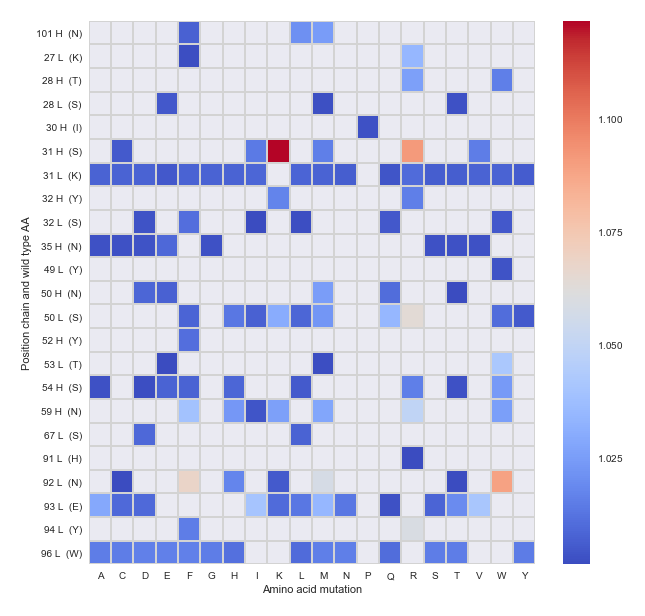

In [54]:
#Generating heatmaps

UNBOUND_CUTOFF = -995
RATIO_CUTOFF = 1.001

#load the data into a pandas dataframe
df = pd.read_csv(csv_file_name, names='Position Amino.Acid Native Bound Unbound Binding WT_Binding WT Ratio'.split(), index_col=False )
#Add wildtype AA to position (for display)
df['Position_WT_aa'] = df.Position + ' (' + df.WT  + ')' 

#filter values
df = df.query(f'Unbound<{UNBOUND_CUTOFF} and Ratio>{RATIO_CUTOFF}')

# convert from tidy format (https://en.wikipedia.org/wiki/Tidy_data) to a wider format
df = pd.pivot_table(df, values='Ratio', 
                     index=['Position_WT_aa'], 
                     columns='Amino.Acid')

#plot the heatmap
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df, cmap='coolwarm', linewidths= 1, linecolor='lightgray')
plt.xlabel('Amino acid mutation');
plt.ylabel('Position chain and wild type AA');
sns.set_context("talk") #make labels bigger

# See Also

Note these may not be available in PyRosetta through code or even by xml (remodel), but they are extremely useful tools when doing denovo protein design - and you should be aware of them.

- **RosettaRemodel**
 - https://www.rosettacommons.org/docs/latest/application_documentation/design/rosettaremodel
    
    
- **Sewing**

 - https://www.rosettacommons.org/docs/latest/scripting_documentation/RosettaScripts/composite_protocols/sewing/SEWING
 
 
-  **Parametric Design**
 - Previous Workshop!

<!--NAVIGATION-->
< [*De Novo* Protein Design with PyRosetta](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.07-Introduction-to-DeNovo-protein-design.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Docking](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/07.00-Protein-Docking.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.08-Point-Mutation-Scan.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>